## Attribution Model Marketing 

Attribution modeling is a framework for analyzing which touchpoints, or marketing channels, receive credit for a conversion. Each attribution model distributes the value of a conversion across each touchpoint differently.
A model comparison tool allows you to analyze how each model distributes the value of a conversion. There are six common attribution models: First Interaction, Last Interaction, Last Non-Direct Click, Linear, Time-Decay, and Position-Based.

By analyzing each attribution model, one can get a better idea of the ROI for each marketing channel/campoaign.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment3\criteo_attribution_dataset')

In [3]:
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

## Data Pre-Processing 

We will pre-process the data using below steps - 

1. We take a sample of 400 Campaigns to do the Attribution Modeling

2. Feature Engineering
  - Creating 'Day' column from Event Timestamp & Conversion Timestamp
  - Creating Journey ID column from Uid & Coversion Id
  - Normalising the timestamps
  
3. Filtering the user journey with a min touchpoints threshold(2)

4. The data is imbalanced for conversions. Balance the data so that Data driven models can be trained

5. Create one hot encoding for Cat1-9 columns and Campaign column

In [4]:
n_campaigns = 400

In [5]:
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)

In [6]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [7]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

In [8]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,29196072,11409686,1973606,25162884,29196072,29196072,0,20073966_-1,0.000000e+00,0.000000
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,29196072,11409686,1973606,22644417,9312274,21091111,0,24607497_-1,7.487274e-07,0.163526
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,29196072,5824237,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,23549932,5824237,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,29196072,11409684,26597096,4480345,29196072,29196072,0,25357769_-1,1.123091e-06,0.000000


In [9]:
np.random.seed(42)
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


In [10]:
df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

In [11]:
df_Criteo_Attribution.shape

(9889488, 26)

In [12]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [13]:
df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)

In [14]:
df_Criteo_Attribution.shape

(7405691, 26)

In [15]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [16]:
df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

In [17]:
df_Criteo_Attribution.shape

(579774, 26)

In [18]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [19]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

In [20]:
df_Criteo_Attribution.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [21]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [22]:
df_Criteo_Attribution.shape

(579774, 28)

In [23]:
[df_Criteo_Attribution[df_Criteo_Attribution.conversion == 0].shape[0], df_Criteo_Attribution[df_Criteo_Attribution.conversion == 1].shape[0]]

[290278, 289496]

In [24]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
65528,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
387213,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
401488,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,1973606,2687461,29841067,21091108,0,93907_-1,1.497455e-06,0.101299,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14394,4,19923387,31772643,0,-1,-1,0,0,-1,-1,...,32440041,14074087,29196072,21091108,0,19923387_-1,1.497455e-06,0.069316,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
473426,4,28451570,20843295,0,-1,-1,0,0,-1,-1,...,28928366,8556462,29196072,29196072,0,28451570_-1,1.497455e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
df_Criteo_Attribution.campaign.unique()

array([18975823, 29427842, 17686799, 31772643, 20843295, 16184517,
       27321366, 13462155, 18443077, 3892353, 23254639, 15422821, 1415896,
       15959625, 3406183, 27684173, 9100689, 2946551, 25064375, 15184511,
       29874688, 3144706, 2144729, 17321082, 24045148, 32452111, 2576437,
       25419531, 16922675, 14445192, 18498193, 9100693, 9106407, 9100691,
       8904991, 20695010, 24391301, 10686810, 3291800, 5544859, 5871888,
       2828357, 7121544, 27888153, 8403848, 17661711, 24378636, 15746419,
       13661597, 29175063, 22589171, 8877963, 30801593, 11028540,
       32452108, 8892339, 28137208, 28739284, 27872610, 30405203,
       22431924, 21096019, 7681481, 9100692, 13300124, 14661605, 8892341,
       22891668, 13576407, 14235907, 26852339, 2077112, 13947793,
       14121532, 16307476, 7877971, 6686701, 30881002, 6686704, 2694554,
       8710016, 23852329, 25259856, 26091094, 26852338, 7289590, 11959615,
       27729624, 12491647, 24389111, 5686703, 14102485, 7686710, 2894

In [26]:
df_Criteo_Attribution.campaigns[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Journey Length

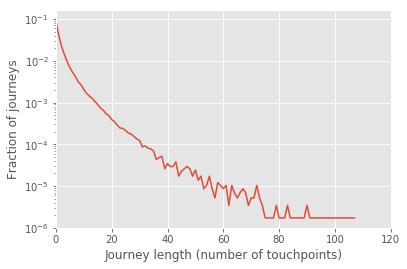

In [27]:
def journey_length_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_histogram(df_Criteo_Attribution)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

### Journey Length for only Journey which got converted 


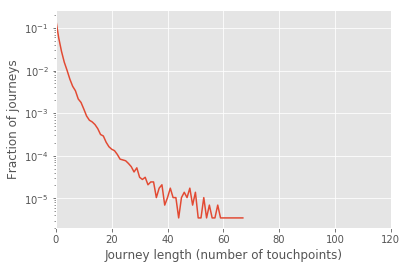

In [28]:
def journey_length_hist(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_hist(df_Criteo_Attribution[df_Criteo_Attribution.conversion==1])

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## Attribution Model Marketing

1. Single Touch Attribution Models:
    - Last touch Attribution 
    - First Touch Attribution

2. Multi-Touch Attribution Models:
    - UShape Attribution
    - TimeDecay Attribution
    - Position Decay Attribution
    - Reverse Decay: Position
    - Linear Attribution
    
3. Data Driven or Machine Learning Attribution:
    - Logistic Regression
    - LSTM (Long short term memory)
    - LSTM with Attention mechanism

## Single Touch Attribution Models

Single-touch attribution models assign 100% of conversion credit to one marketing touchpoint. Even if a customer saw 20 ads before converting, single-touch attribution will determine that only 1 of the 20 ads deserves conversion credit.

Single-touch attribution models are easy to implement because of their low level of complexity. They’re also the most popular attribution models because of their historical tie to Google Ads (formerly AdWords).

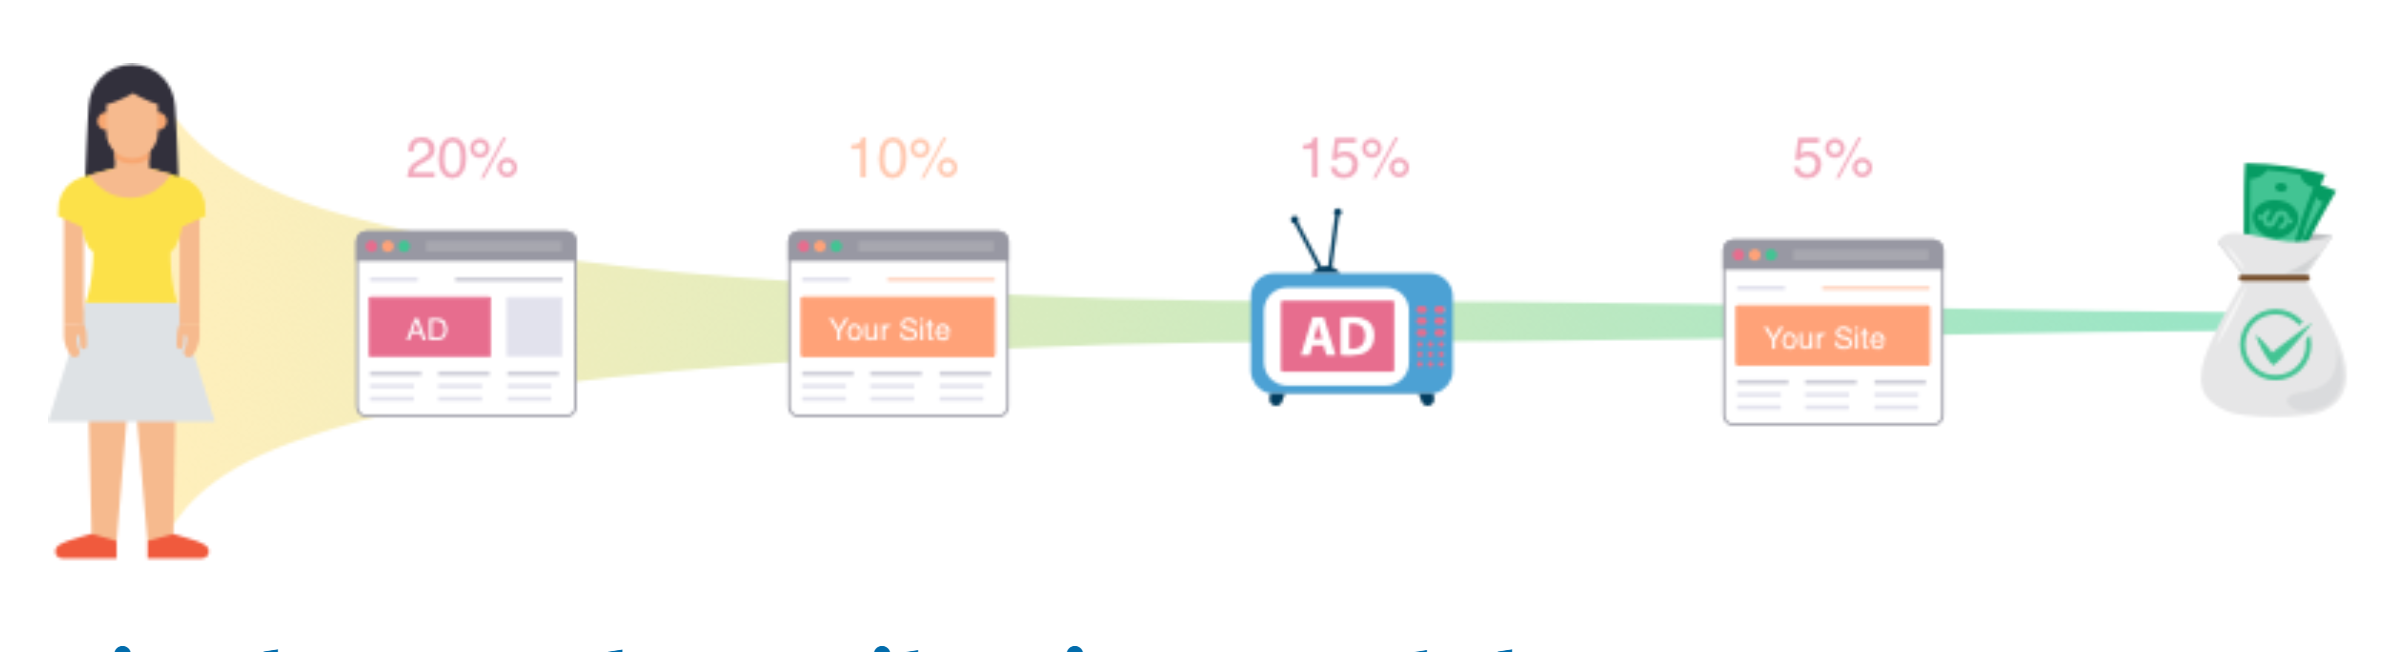

In [79]:
from IPython.display import Image
Image('theme.png')

### 1. Last Touch Attribution Model - 

Last-touch attribution assigns 100% of the credit to the last marketing touchpoint. This model would give all the credit to the striker (Player E in the image below).
You could argue that the last touch is all that matters because it resulted in the actual conversion, but it doesn’t tell the whole story. Your customers are likely engaging with your brand across multiple touchpoints on various channels before they convert.

In [29]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df_Criteo_Attribution)

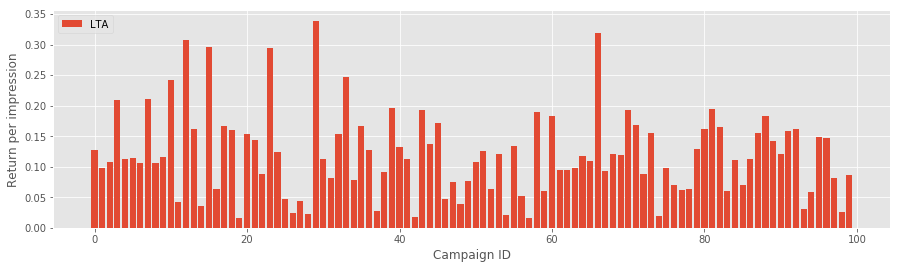

In [30]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [31]:
lta

array([0.09705793, 0.13974942, 0.07729954, 0.07579186, 0.08419814,
       0.24414182, 0.17793972, 0.12727273, 0.23183641, 0.10688406,
       0.11270601, 0.11861862, 0.05482042, 0.08497653, 0.03737605,
       0.10154097, 0.28222997, 0.18417722, 0.11760576, 0.10967742,
       0.2808399 , 0.06763285, 0.25246792, 0.29115293, 0.31634078,
       0.10994764, 0.22018349, 0.06220096, 0.24547461, 0.33406367,
       0.09057528, 0.12959641, 0.13981358, 0.08618654, 0.078     ,
       0.24432678, 0.16831683, 0.07557903, 0.12011173, 0.34461054,
       0.0558356 , 0.06996587, 0.17121945, 0.12300208, 0.15711253,
       0.03071364, 0.10257948, 0.17252445, 0.09819121, 0.06890894,
       0.18832891, 0.21254682, 0.02769416, 0.32009346, 0.07633982,
       0.14797136, 0.19684829, 0.13486117, 0.28232594, 0.1345496 ,
       0.13427562, 0.13943721, 0.1421757 , 0.0564872 , 0.10679612,
       0.16196918, 0.1232314 , 0.06072508, 0.13574661, 0.17508106,
       0.1000706 , 0.33151462, 0.18504673, 0.10269914, 0.15548

### 2. First Touch Attribution Model - 

With a first-touch attribution model, your first marketing interaction receives 100% of the credit. 

If you’re mainly focused on widening top of your funnel, this is a useful model. It highlights the channels that first introduced a customer to your brand.

The problem? It ignores all subsequent touches, and therefore provides no insight into your down-funnel metrics. A Facebook ad may send you a lot of website traffic, but probably isn’t the sole influencer in a conversion.

In [32]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df_Criteo_Attribution)

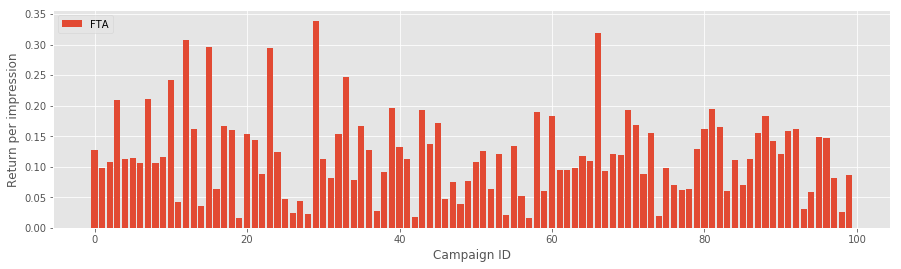

In [33]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [34]:
fta

array([0.09705793, 0.13974942, 0.07729954, 0.07579186, 0.08419814,
       0.24414182, 0.17793972, 0.12727273, 0.23183641, 0.10688406,
       0.11270601, 0.11861862, 0.05482042, 0.08497653, 0.03737605,
       0.10154097, 0.28222997, 0.18417722, 0.11760576, 0.10967742,
       0.2808399 , 0.06763285, 0.25246792, 0.29115293, 0.31634078,
       0.10994764, 0.22018349, 0.06220096, 0.24547461, 0.33406367,
       0.09057528, 0.12959641, 0.13981358, 0.08618654, 0.078     ,
       0.24432678, 0.16831683, 0.07557903, 0.12011173, 0.34461054,
       0.0558356 , 0.06996587, 0.17121945, 0.12300208, 0.15711253,
       0.03071364, 0.10257948, 0.17252445, 0.09819121, 0.06890894,
       0.18832891, 0.21254682, 0.02769416, 0.32009346, 0.07633982,
       0.14797136, 0.19684829, 0.13486117, 0.28232594, 0.1345496 ,
       0.13427562, 0.13943721, 0.1421757 , 0.0564872 , 0.10679612,
       0.16196918, 0.1232314 , 0.06072508, 0.13574661, 0.17508106,
       0.1000706 , 0.33151462, 0.18504673, 0.10269914, 0.15548

In [35]:
lta == fta

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Multi-Touch Attribution Models

### 3. Linear or Even-Weight Model

Often referred to as linear, even-weight distributes all credit evenly.
Even-weight is more sophisticated than a single-touch model — it doesn’t ignore all the touchpoints in the middle of the conversion path.

The downside is that not all touchpoints are created equal. This model essentially says that every campaign or channel gets awarded for advertising, which is unfair to the best 
performing ways.

In [36]:
def Linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)
    
    def linear_attr_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 28]
        
        return counters
    
    campaign_conversions = linear_attr_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    
linear_a = Linear_attribution(df_Criteo_Attribution)

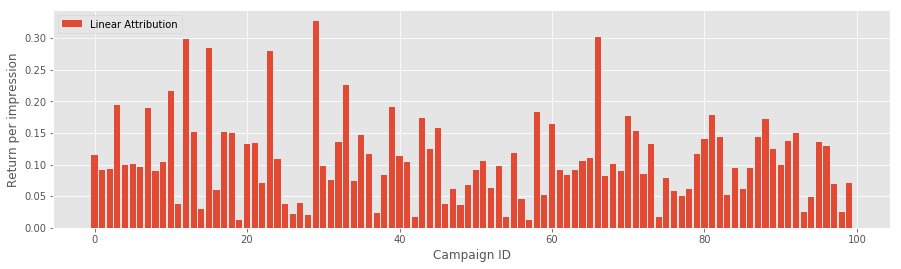

In [37]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(linear_a[campaign_idx])), linear_a[campaign_idx], label='Linear Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [38]:
linear_a

array([0.08278455, 0.12172435, 0.06843146, 0.06934962, 0.07038305,
       0.22346293, 0.15620895, 0.10910966, 0.2129029 , 0.10249597,
       0.09461183, 0.09965266, 0.04438049, 0.06950869, 0.03050319,
       0.09066149, 0.25893982, 0.16448632, 0.09738226, 0.09732723,
       0.26002214, 0.05501179, 0.23013659, 0.2717402 , 0.30240771,
       0.09385134, 0.21176096, 0.05386552, 0.21669605, 0.31657582,
       0.0726551 , 0.11337033, 0.1272865 , 0.07796525, 0.06870552,
       0.22371298, 0.15379538, 0.06335023, 0.10483693, 0.33064517,
       0.04626934, 0.06208083, 0.14995596, 0.1038813 , 0.14130316,
       0.02540894, 0.08613343, 0.15229442, 0.08897748, 0.05938036,
       0.15713111, 0.19008195, 0.02511466, 0.30633066, 0.06303027,
       0.12375756, 0.16039034, 0.12175469, 0.26698165, 0.11400039,
       0.11958186, 0.11935788, 0.12116965, 0.04410282, 0.09509056,
       0.13835992, 0.10899073, 0.05621493, 0.10681448, 0.14928164,
       0.08839785, 0.32072652, 0.16755967, 0.09350277, 0.13681

In [39]:
linear_a == fta

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [40]:
df_Criteo_Attribution.shape

(579774, 28)

### 4. U-Shape Model 

The U-shape model gives 40% of conversion credit to the first and last marketing touchpoints. The remaining 20% is distributed evenly among all touchpoints in between.

In [41]:
def UShape_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(click_pos,click_nb):
        default_att = 0.5
        extreme_touch_att = 0.4
        intermed_att = 0.2

        if(click_nb == 2):
            return default_att
        else:
            if(click_pos == click_nb - 1 or click_pos ==0):
                return extreme_touch_att
            else:
                return intermed_att/(click_nb -2)

    
    def UShape_Attr_Value(df_converted):
        df_converted['U_Shape'] = df_converted.apply(lambda val: calc_attribution(val.click_pos,val.click_nb),axis=1)
        return df_converted
        
    def UShape_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 28]
        return counters
    
    
    #df_converted['U_Shape'] = df_converted.apply(lambda val: calc_attribution(val.click_pos,val.click_nb),axis=1)
    df_converted = UShape_Attr_Value(df_converted) 
    
    campaign_conversions = UShape_by_campaign(df_converted)   #count conversions by campaign using U-Shape model
        
    return campaign_conversions / campaign_impressions
    
UShape_attr = UShape_attribution(df_Criteo_Attribution)

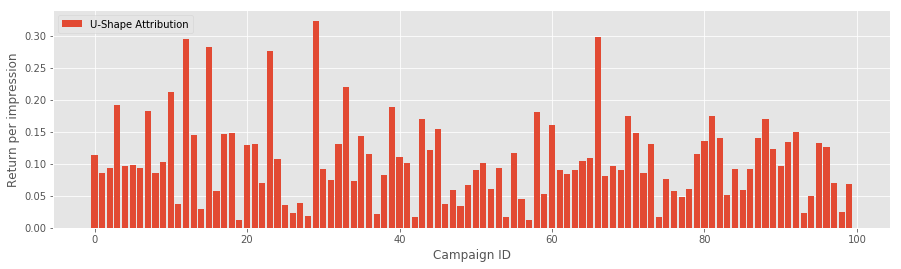

In [42]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(UShape_attr[campaign_idx])), UShape_attr[campaign_idx], label='U-Shape Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [43]:
UShape_attr

array([0.08073166, 0.11912784, 0.06738348, 0.06798194, 0.06824931,
       0.22044125, 0.1530021 , 0.10650775, 0.20906016, 0.10133282,
       0.09082066, 0.09759216, 0.04294095, 0.06760237, 0.02853136,
       0.08913358, 0.25712616, 0.16131922, 0.09515006, 0.09618258,
       0.25814973, 0.05350873, 0.22721303, 0.26947109, 0.30020221,
       0.09130248, 0.21094028, 0.05216181, 0.2126036 , 0.31345675,
       0.06891652, 0.11059309, 0.12417615, 0.0764044 , 0.06774146,
       0.22044761, 0.15115512, 0.06211412, 0.10318245, 0.32836437,
       0.04578106, 0.06072647, 0.14871418, 0.10179842, 0.13831092,
       0.02455377, 0.08378838, 0.15015979, 0.08788718, 0.05804795,
       0.15584765, 0.18712895, 0.02509037, 0.30383178, 0.06141227,
       0.12059929, 0.15616139, 0.12031406, 0.26488174, 0.11153666,
       0.1168139 , 0.11652474, 0.11700431, 0.04237598, 0.09294629,
       0.13500432, 0.10653508, 0.05534239, 0.10847478, 0.14564986,
       0.08698775, 0.31956645, 0.16575655, 0.09144488, 0.13416

In [44]:
UShape_attr == linear_a

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### 5. Time Decay Attribution 

Time decay assumes that the closer a touchpoint is to a conversion, the more influential it is. 

##### We have 30 days of time window in the dataset. We will extract the day from the timestamp and then use time to decay the attribution weights. The decay function we use here is 

2^(-X/half life)

where X is the time out from the coversion day. 
X = Conversion day- Click day

half life = 7 (This can be calculated for different business needs. Usually its assumed to be 7 for online platforms)


In [45]:
df_Criteo_Attribution['conversion_day'] = np.floor(df_Criteo_Attribution.conversion_timestamp / 86400.).astype(int)

In [46]:
df_Criteo_Attribution.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'day', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'conversion_day'],
      dtype='object')

In [47]:
df_Criteo_Attribution.shape

(579774, 29)

In [48]:
def TimeDecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        #print('here 1')
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(conversion_day,click_day):
        rel_pos =  conversion_day - click_day
        attribution = pow(2, -(rel_pos/7))    # using formulae 2^-x/7
        return attribution
    
    def TimeDecay_Attr_Value(df_converted):
        df_converted['TimeDecay'] = df_converted.apply(lambda val: calc_attribution(val.conversion_day,val.day),axis=1)
        return df_converted
        
    def Normalised_TimeDecay(journey_id, Time_Decay):
        attr_sum = df_TDecay_Sum[df_TDecay_Sum.jid == journey_id]['TDsum']
        return Time_Decay / attr_sum       #normalising the attributions by dividing each with the sum of attributions
            
    def TimeDecay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
        
        
    
    df_converted = TimeDecay_Attr_Value(df_converted) 
    
    #df_TDecay_Sum = df_converted.groupby(['jid'])['TimeDecay'].sum().reset_index(name="TDsum")
    #df_converted = df_converted.merge(df_TDecay_Sum, on='jid', how='left')
    #df_converted['TimeDecay_Norm'] = df_converted.TimeDecay / df_converted.TDsum
    #df_converted.apply(lambda val: Normalised_TimeDecay(val.jid,val.TimeDecay),axis=1)
    
    campaign_conversions = TimeDecay_by_campaign(df_converted)   #count conversions by campaign using U-Shape model
        
    return campaign_conversions / campaign_impressions
    
TimeDecay_attr = TimeDecay_attribution(df_Criteo_Attribution)

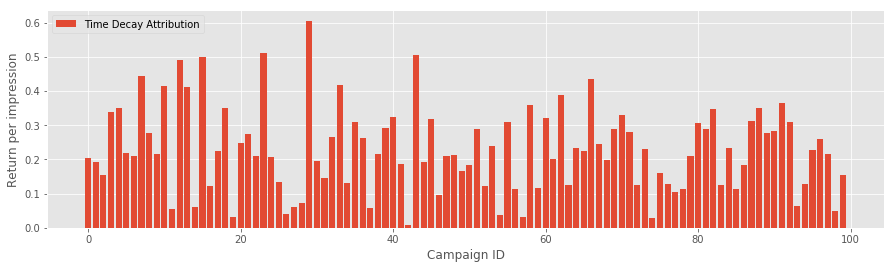

In [49]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(TimeDecay_attr[campaign_idx])), TimeDecay_attr[campaign_idx], label='Time Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [50]:
TimeDecay_attr

array([0.2035063 , 0.26403117, 0.1370512 , 0.14531383, 0.1948935 ,
       0.53910106, 0.3285472 , 0.26270447, 0.48087751, 0.1360369 ,
       0.25555599, 0.21823319, 0.15317343, 0.17269104, 0.09528556,
       0.17544756, 0.605235  , 0.40421682, 0.27000151, 0.21294789,
       0.63231748, 0.14605721, 0.50145257, 0.50696927, 0.53587625,
       0.25400041, 0.48322303, 0.14570813, 0.3498911 , 0.56442226,
       0.25730758, 0.2652659 , 0.26075879, 0.2065991 , 0.13314509,
       0.3832231 , 0.26760487, 0.26678157, 0.22907701, 0.57733858,
       0.09954965, 0.11613941, 0.53836067, 0.25233146, 0.38225289,
       0.07097181, 0.2111686 , 0.35375045, 0.17439859, 0.16190905,
       0.35397985, 0.37236312, 0.0505965 , 0.5144139 , 0.17822205,
       0.28179954, 0.30934917, 0.27117743, 0.56570461, 0.19541273,
       0.23790395, 0.28988906, 0.31423647, 0.18327858, 0.22597376,
       0.31181232, 0.24692039, 0.09466455, 0.2050599 , 0.3051526 ,
       0.19910053, 0.71023427, 0.32099554, 0.1640601 , 0.37790

### 6. Position Based Decay: Custom Method

This model assumes that the closer a touchpoint is to a conversion in the journey, the more influential it is. 

#####  We will only use the position of each touchpoint in the journey relative the the conversion point and use the below decay function 

2^(-n)


In [51]:
def PositionDecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(click_pos,click_nb):
        rel_pos =  click_nb - click_pos
        attribution = pow(2, -(rel_pos))    # using formulae 2^-n
        return attribution
    
    def PosDecay_Attr_Value(df_converted):
        df_converted['TimeDecay'] = df_converted.apply(lambda val: calc_attribution(val.click_pos,val.click_nb),axis=1)
        return df_converted
        
    def PosDecay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
    
    
    df_converted = PosDecay_Attr_Value(df_converted) 
    
    #df_TDecay_Sum = df_converted.groupby(['jid'])['TimeDecay'].sum().reset_index(name="TDsum")
    #df_converted = df_converted.merge(df_TDecay_Sum, on='jid', how='left')
    #df_converted['TimeDecay_Norm'] = df_converted.TimeDecay / df_converted.TDsum
    
    campaign_conversions = PosDecay_by_campaign(df_converted)   #count conversions by campaign using Position Decay model
        
    return campaign_conversions / campaign_impressions
    
PositionDecay_attr = PositionDecay_attribution(df_Criteo_Attribution)

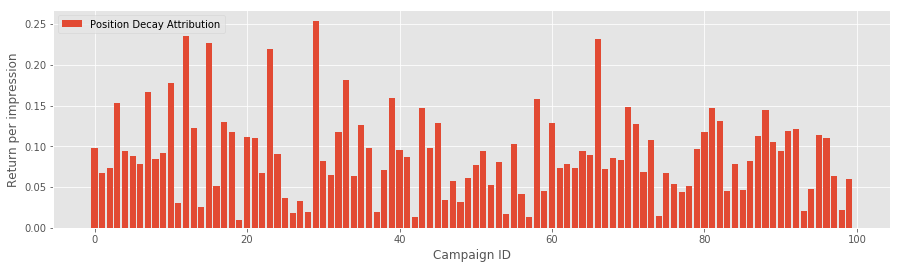

In [52]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(PositionDecay_attr[campaign_idx])), PositionDecay_attr[campaign_idx], label='Position Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [53]:
PositionDecay_attr

array([0.07090455, 0.10545227, 0.05889579, 0.05608108, 0.06367152,
       0.18569547, 0.13179371, 0.0945601 , 0.17625183, 0.08025858,
       0.08518809, 0.08750916, 0.04096281, 0.05719627, 0.02906863,
       0.07718222, 0.22343432, 0.1406829 , 0.08304848, 0.08567632,
       0.22033123, 0.04725337, 0.18825477, 0.22437301, 0.23598011,
       0.08417181, 0.17177869, 0.04809117, 0.17996843, 0.25092901,
       0.06459891, 0.09705125, 0.10845841, 0.07025456, 0.05546438,
       0.18244505, 0.12314356, 0.05687672, 0.09018864, 0.25770623,
       0.04029131, 0.05256439, 0.13172688, 0.08942572, 0.12748495,
       0.0215699 , 0.07312888, 0.13244695, 0.07254052, 0.05308601,
       0.13998343, 0.16468065, 0.02080895, 0.2374028 , 0.0561125 ,
       0.10648403, 0.14384821, 0.10357408, 0.21340294, 0.09165935,
       0.1070561 , 0.10077144, 0.10671291, 0.04288371, 0.08199998,
       0.11914291, 0.09484094, 0.04724562, 0.09363538, 0.12848924,
       0.07539972, 0.26391089, 0.14256604, 0.07746891, 0.12185

In [54]:
PositionDecay_attr == TimeDecay_attr

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### 7. Reverse Position Decay : Custom Method

Here we give the most credit to the initial touchpoints which are away from conversion. As the time gets closer to conversion, we decay the credit given to each touchpoint using the formulae 2^-n. This is the exact opposite to the last method.

In [55]:
def Reverse_PositionDecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(click_pos,click_nb):
        rel_pos =  click_pos + 1
        attribution = pow(2, -(rel_pos))    # using formulae 2^-n
        return attribution
    
    def TimeDecay_Attr_Value(df_converted):
        df_converted['TimeDecay'] = df_converted.apply(lambda val: calc_attribution(val.click_pos,val.click_nb),axis=1)
        return df_converted
        
    def TimeDecay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
    
    
    df_converted = TimeDecay_Attr_Value(df_converted) 
    
    #df_TDecay_Sum = df_converted.groupby(['jid'])['TimeDecay'].sum().reset_index(name="TDsum")
    #df_converted = df_converted.merge(df_TDecay_Sum, on='jid', how='left')
    #df_converted['TimeDecay_Norm'] = df_converted.TimeDecay / df_converted.TDsum
    
    campaign_conversions = TimeDecay_by_campaign(df_converted)   #count conversions by campaign using U-Shape model
        
    return campaign_conversions / campaign_impressions
    
Rev_PosDecay_attr = Reverse_PositionDecay_attribution(df_Criteo_Attribution)

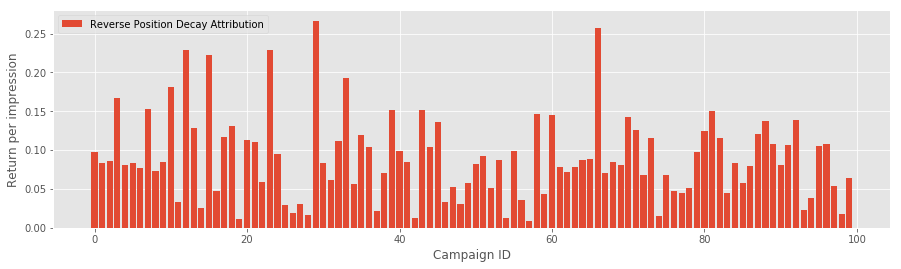

In [56]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(Rev_PosDecay_attr[campaign_idx])), Rev_PosDecay_attr[campaign_idx], label='Reverse Position Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [57]:
Rev_PosDecay_attr

array([0.07264647, 0.10503649, 0.05634134, 0.06032316, 0.05884633,
       0.19171983, 0.13356017, 0.09423828, 0.18175497, 0.08317765,
       0.07945493, 0.08358803, 0.03878604, 0.06373796, 0.02536902,
       0.07586172, 0.21778347, 0.13595031, 0.08858087, 0.07997495,
       0.21474369, 0.04884172, 0.19173646, 0.21291859, 0.23602299,
       0.07718213, 0.16701005, 0.04564894, 0.18196749, 0.25386948,
       0.06507727, 0.09820657, 0.10887018, 0.06416625, 0.06013849,
       0.19027899, 0.13056931, 0.05591505, 0.08970863, 0.26329547,
       0.04039921, 0.0512312 , 0.13371106, 0.08988771, 0.12094032,
       0.02281798, 0.07585734, 0.1265384 , 0.0752211 , 0.04990708,
       0.13347582, 0.15570317, 0.02120871, 0.24485251, 0.05543474,
       0.10539526, 0.13070193, 0.10302536, 0.21718055, 0.10303597,
       0.09609306, 0.10496531, 0.10592785, 0.03643947, 0.08106693,
       0.11837146, 0.09121769, 0.04620774, 0.08907152, 0.12633607,
       0.07396283, 0.24959093, 0.13959869, 0.07719409, 0.11432

In [58]:
PositionDecay_attr == Rev_PosDecay_attr

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### 8. Mode Based Attribution

In this method we can calculate the mode Campaign/Channel in each journey and attribute 100% to credit to the mode campaign, or equally divide in case if we ahve multiple modes. 

As in the given dataset, there is only 1 Campaign associated with each journey, the mode will always be that campaign itself, so the Attribution weights will be same as that of LTA or FTA. We need not implement this for our dataset. But can be implemented if we have multiple channels/campaigns. 

## Save Attribution Weights

In [62]:
np.savetxt("lta.txt", lta)
np.savetxt("fta.txt", lta)
np.savetxt("Linear.txt", linear_a)
np.savetxt("UShape.txt", UShape_attr)
np.savetxt("TimeDecay.txt", TimeDecay_attr)
np.savetxt("PositionDecay.txt", PositionDecay_attr)
np.savetxt("ReversePosDecay.txt", Rev_PosDecay_attr)

In [63]:
#y = np.loadtxt("lta.txt")
#y

### Comparison of Different Models

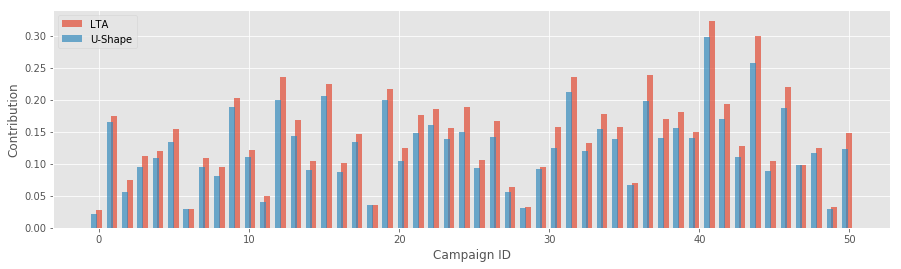

In [64]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, UShape_attr[campaign_idx], width=0.4, alpha=0.7, label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

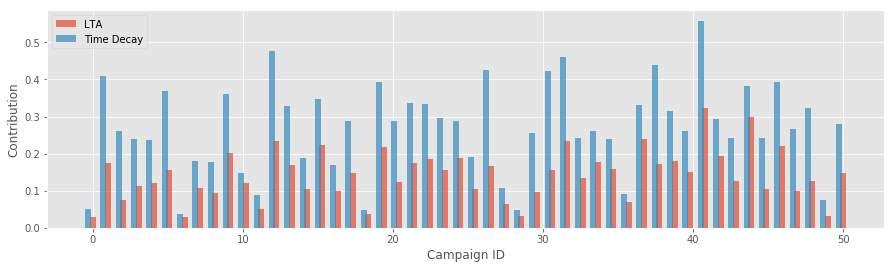

In [65]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, TimeDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

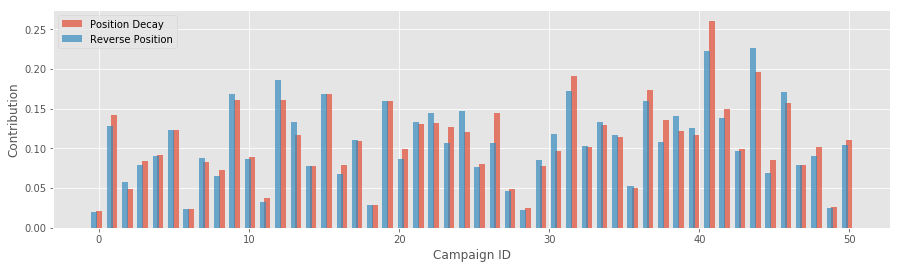

In [66]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, Rev_PosDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Reverse Position' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

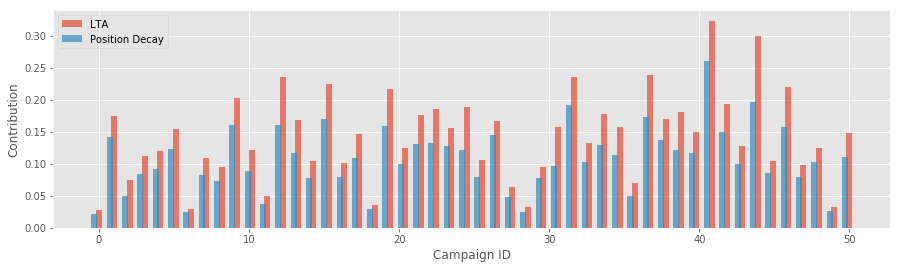

In [67]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

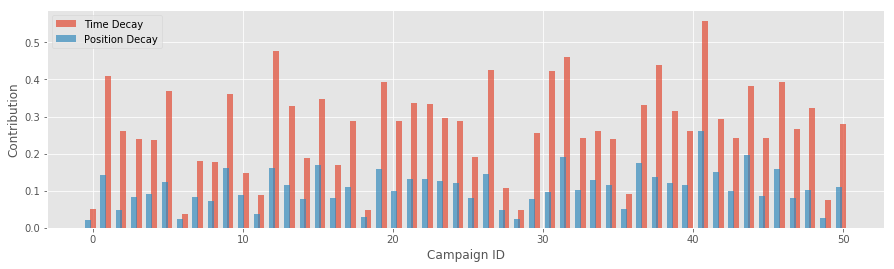

In [68]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

#### Line Plots 

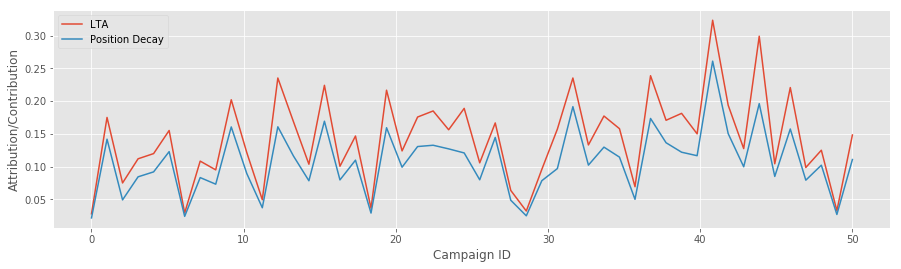

In [69]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), PositionDecay_attr[campaign_idx], label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

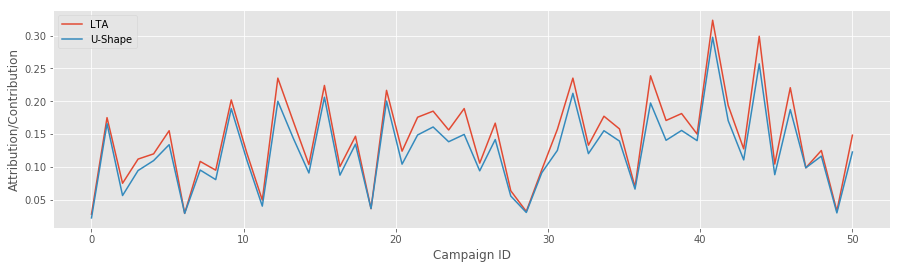

In [70]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), fta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape_attr[campaign_idx], label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

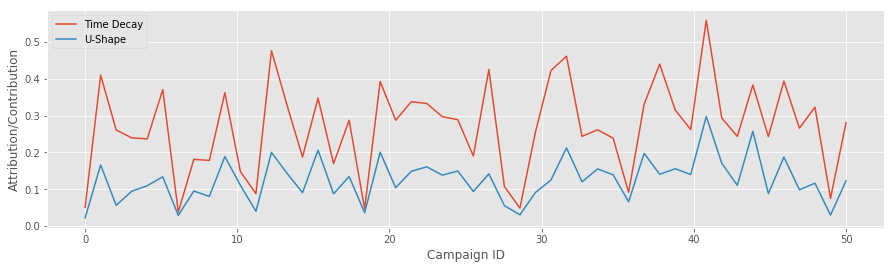

In [71]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx], label='Time Decay' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape_attr[campaign_idx], label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

In [72]:
df_Criteo_Attribution.to_csv('Criteo_Attribution_data.csv')